# Evaluating a Function that Extracts Project Names from Customer Emails

The same test as you can find in [project_name_extractor_evaluation/03.1_evaluate_function_without_donation.ipynb](03.1_evaluate_function_without_donation.ipynb). The similarity threshold for the function is 0.185

In [1]:
import os
import sys

# Add the path to the directory containing the 'services' module
module_paths = ['/home/jovyan/work/smart_mail/src', '/home/jovyan/work/notebook/utils']
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

# Verify that the path is added
print(sys.path)

['/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/home/jovyan/.local/lib/python3.11/site-packages', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/smart_mail/src', '/home/jovyan/work/notebook/utils']


In [2]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from services.content.project_identifier_service import ProjectIdentifierService
from project_name_extractor_utils import get_project_list
from dtos.project import Project

from importlib import reload
from dtos.identified_project import IdentifiedProject

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
similarity_threshold: float = 0.180
ground_truth_csv_path = "/home/jovyan/work/notebook/project_name_extractor_evaluation/ground_truth.csv"

In [6]:
# Read Ground Truth CSV Data
data = pd.read_csv(ground_truth_csv_path, delimiter=";")

# Load the data into a DataFrame
df = pd.DataFrame(data)

Replace "NaN" with an empty string in the expected project names to avoid issues with comparison.

In [7]:
df = df.fillna("")

In [8]:
df

,source_system,project_id,project_name,subject,body
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh..."
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E..."
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ..."
...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...


In [9]:
projects = get_project_list()
filtered_project_names = [project.name for project in projects if 'Spendenprojekt - Green Forest Fund' not in project.name]
project_identifier_service = ProjectIdentifierService(filtered_project_names)

In [10]:
filtered_project_names

['DFI Zukunftspark Oberfranken VI',
 'Berliner Flair in Friedrichshain II',
 'DFI Zukunftspark Nordbayern IV',
 'DFI Zukunftspark Oberfranken V',
 'Am Akkonplatz',
 'Berliner Flair in Friedrichshain',
 'DFI Zukunftspark Oberfranken IV',
 'Tonhallen-Passage II',
 'DFI Zukunftspark Nordbayern III',
 'DFI Zukunftspark Oberfranken III',
 'DFI Zukunftspark Dreiländereck II',
 'Friedrichstraße 191 III',
 'Office am Europaring IV',
 'DFI Zukunftspark Mittelfranken',
 'Wohnquartier Pasing II',
 'DFI Zukunftspark Dreiländereck',
 'smart-UP Self-Storage-Park III',
 'Stadthaus Mozart IV',
 'Stadthaus Mozart III',
 'Büro-Hochhaus am Scheidemannplatz II',
 'smartUP Self-Storage-Park II',
 'Jugendstil-Altbau am Rothenbaum II',
 'Stadtleben Altlindenau',
 'An der Kleinen Weser',
 'Modernes Wohnen am Nymphenburger Kanal II',
 'Atelier-Wohnungen an der Burg II',
 'Eco Living Lichtenrade',
 'The Five',
 'Elegantes Wohnen nahe der Isar',
 'Solarpark Eyendorf',
 'DFI Zukunftspark Oberrhein II',
 'DFI Zuku

In [11]:

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_as_dict = row.to_dict()
    input_text = (row_as_dict["subject"] + " " + row_as_dict["body"]).strip()
    extracted_project: IdentifiedProject = project_identifier_service.extract_project(input_text, similarity_threshold)
    if extracted_project == None:
        df.at[idx, "extracted_project_name"] = ""
        continue

    df.at[idx, "extracted_project_name"] = extracted_project.name
    df.at[idx, "extracted_project_similarity"] = extracted_project.similarity

100%|██████████| 212/212 [08:08<00:00,  2.30s/it]


In [12]:
df

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh...",dfi zukunftspark oberfranken ii,0.434460
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...,dfi zukunftspark oberfranken iv,0.491223
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E...",dfi zukunftspark oberfranken,0.506988
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...,dfi zukunftspark oberfranken vi,0.467600
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ...",dfi zukunftspark oberfranken vi,0.512745
...,...,...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...,,NaN
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...,,NaN
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...,,NaN
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...,,NaN


In [13]:
# Ground truth and predictions
y_true = df['project_name']
y_pred = df['extracted_project_name']

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.11320754716981132
Precision: 0.008108108108108109
Recall: 0.0125
F1 Score: 0.009836065573770491


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jovyan/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Analyze the results

Find rows where the values are not the same

In [14]:
mask = df["project_name"] != df["extracted_project_name"]
different_values_df = df[mask]
len(different_values_df)

188

In [15]:
different_values_df

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh...",dfi zukunftspark oberfranken ii,0.434460
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...,dfi zukunftspark oberfranken iv,0.491223
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E...",dfi zukunftspark oberfranken,0.506988
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...,dfi zukunftspark oberfranken vi,0.467600
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ...",dfi zukunftspark oberfranken vi,0.512745
...,...,...,...,...,...,...,...
183,evdi,AFDD98B3-B93C-4803-8D60-FF1733217768,Stadthaus 'Mozart' II,Wie hoch ist die erwartete Rendite beim Stadth...,Welche Renditeprognosen gibt es für dieses Pro...,stadthaus mozart ii,0.234443
184,evdi,AFDD98B3-B93C-4803-8D60-FF1733217768,Stadthaus 'Mozart' II,Welche Sicherheiten gibt es beim Stadthaus 'Mo...,"Welche Maßnahmen werden ergriffen, um das Risi...",stadthaus mozart ii,0.275945
185,evdi,AFDD98B3-B93C-4803-8D60-FF1733217768,Stadthaus 'Mozart' II,Wann beginnt die Auszahlung der Zinsen für die...,Wann erhalte ich die ersten Zinszahlungen für ...,stadthaus mozart ii,0.270954
186,evdi,AFDD98B3-B93C-4803-8D60-FF1733217768,Stadthaus 'Mozart' II,Welche Absicherung gibt es für die Investition?,Ich würde gerne mehr über die Sicherheit des P...,stadthaus mozart ii,0.257771


Let's investigate some of them:

In [16]:
expected_project_name = "Am Akkonplatz"
input_text = "Wie ist das Risiko beim Projekt Am Akkonplatz eingeschätzt? Wie wird das Risiko bei diesem Investment eingeschätzt? Gibt es Schutzmechanismen, um mein Kapital zu sichern, falls das Projekt nicht erfolgreich ist?"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

In [17]:
expected_project_name = "Wohnquartier Pasing II"
input_text = "Fragen zur Projektlaufzeit und Auszahlungsmodalitäten Sehr geehrtes Projektteam, ich habe einige Fragen bezüglich der zeitlichen Aspekte und Auszahlungsmodalitäten des Investments. Wie lange ist die geplante Laufzeit des Wohnprojekts in Pasing? Ab wann können Investoren mit den ersten Ausschüttungen rechnen? Gibt es einen festen Auszahlungsplan oder sind die Zahlungen an bestimmte Meilensteine im Bauprozess geknüpft? Besteht die Möglichkeit einer vorzeitigen Kündigung oder eines Verkaufs der Anteile? Ich würde mich über detaillierte Informationen zu diesen Punkten sehr freuen, da sie für meine Investitionsplanung von großer Bedeutung sind. Das Projekt ist Wohnquartier Pasing II"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

In [18]:
expected_project_name = "Büro-Hochhaus am Scheidemannplatz II"
input_text = "Sicherheiten und Risikoabsicherung beim Immobilieninvestment Sehr geehrte Damen und Herren, als potenzieller Investor möchte ich mich nach den Sicherheiten erkundigen, die Sie für Investments in Ihr Projekt bieten. Welche konkreten Maßnahmen haben Sie ergriffen, um das Risiko für Investoren zu minimieren? Gibt es eine Absicherung durch Grundbucheinträge oder andere rechtliche Konstrukte? Mich würde auch interessieren, wie Sie mit möglichen Verzögerungen im Bauprozess oder unerwarteten Kostensteigerungen umgehen. Beim Projekt Büro-Hochhaus am Scheidemannplatz II, wie stellen Sie sicher, dass die Interessen der Investoren gewahrt bleiben?"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

Check how many unique project names are in the dataset and how often they appear:

In [19]:
print(df['project_name'].value_counts())

project_name
                                             24
DFI Zukunftspark Dreiländereck                8
DFI Zukunftspark Nordbayern IV                6
DFI Zukunftspark Oberfranken V                6
Am Akkonplatz                                 6
Berliner Flair in Friedrichshain              6
DFI Zukunftspark Oberfranken IV               6
DFI Zukunftspark Nordbayern III               6
DFI Zukunftspark Oberfranken VI               6
Berliner Flair in Friedrichshain II           6
smartUP Self-Storage-Park II                  6
DFI Zukunftspark Oberfranken III              6
Wohnquartier Pasing II                        6
DFI Zukunftspark Dreiländereck II             6
smart-UP Self-Storage-Park III                6
Stadthaus Mozart IV                           6
Büro-Hochhaus am Scheidemannplatz II          6
DFI Zukunftspark Mittelfranken                6
Stadthaus Mozart III                          6
Tonhallen-Passage II                          5
Stadthaus 'Mozart'         

Compare Predictions and Ground Truth:

In [20]:
mismatches = df[df['project_name'] != df['extracted_project_name']]
print(mismatches[['project_name', 'extracted_project_name']])

                        project_name           extracted_project_name
0    DFI Zukunftspark Oberfranken VI  dfi zukunftspark oberfranken ii
1    DFI Zukunftspark Oberfranken VI  dfi zukunftspark oberfranken iv
2    DFI Zukunftspark Oberfranken VI     dfi zukunftspark oberfranken
3    DFI Zukunftspark Oberfranken VI  dfi zukunftspark oberfranken vi
4    DFI Zukunftspark Oberfranken VI  dfi zukunftspark oberfranken vi
..                               ...                              ...
183            Stadthaus 'Mozart' II              stadthaus mozart ii
184            Stadthaus 'Mozart' II              stadthaus mozart ii
185            Stadthaus 'Mozart' II              stadthaus mozart ii
186            Stadthaus 'Mozart' II              stadthaus mozart ii
187            Stadthaus 'Mozart' II              stadthaus mozart ii

[188 rows x 2 columns]


## Examine Confusion Matrix

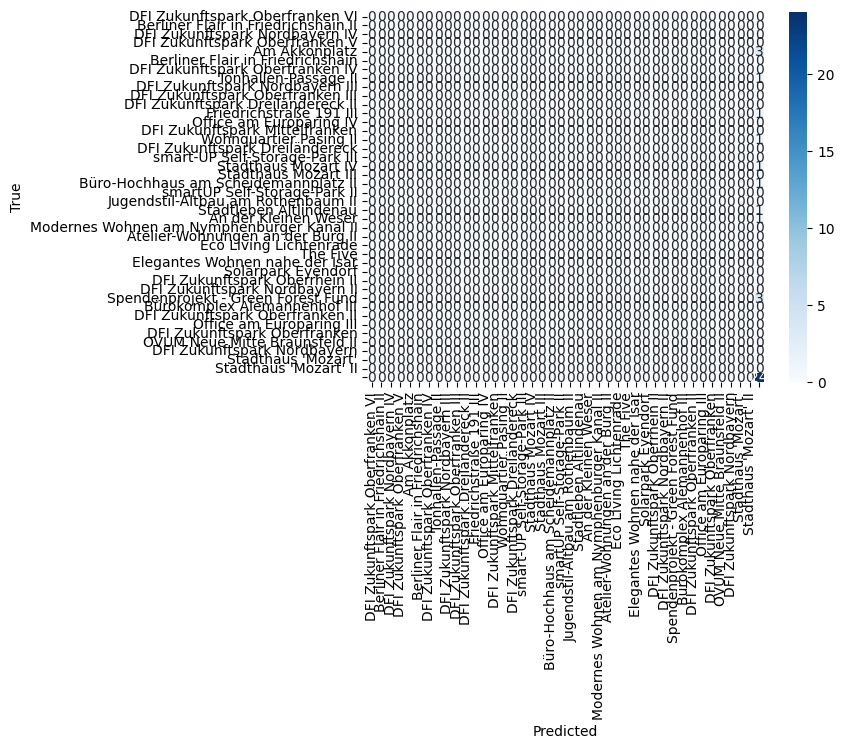

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=df['project_name'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['project_name'].unique(), yticklabels=df['project_name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## The similarity of the project names

In [22]:
mask = df["project_name"] == df["extracted_project_name"]
correct_predicted_values = df[mask]

correct_predicted_values

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
188,evdi,,,Welche Laufzeit hat das Investmentprojekt?,"Könnten Sie mir bitte mitteilen, wie lange das...",,NaN
189,evdi,,,Wie wird das Kapital geschützt?,Ich möchte gerne mehr über die Maßnahmen erfah...,,NaN
190,evdi,,,Wie wird die Finanzierung des Projekts gesichert?,Ich würde gerne mehr über die Sicherheiten des...,,NaN
191,evdi,,,Ab wann erhalte ich die erste Rendite?,Wann beginnt die Auszahlung der Zinsen für die...,,NaN
192,evdi,,,Wie lange dauert die Projektlaufzeit?,Wie lange ist die geplante Laufzeit dieses Pro...,,NaN
193,evdi,,,Welche Sicherheiten gibt es für mein Investment?,Welche vertraglichen Sicherheiten werden Inves...,,NaN
194,evdi,,,Wie lange dauert die Finanzierung dieses Proje...,Wie lange ist die geplante Dauer der Finanzier...,,NaN
195,evdi,,,Welche Sicherheiten gibt es für Investoren?,"Welche Maßnahmen werden unternommen, um mein I...",,NaN
196,evdi,,,Wann beginnen die Zinszahlungen?,Ab wann kann ich mit den Zinszahlungen rechnen...,,NaN
197,evdi,,,Welche Zinssätze werden für mein Investment er...,"Wie hoch sind die Zinsen, die ich als Investor...",,NaN


In [23]:
similarity_min = df["extracted_project_similarity"].min()
similarity_min

np.float64(0.18369635939598083)

In [24]:
df["extracted_project_similarity"].describe()

count    175.000000
mean       0.375366
std        0.110029
min        0.183696
25%        0.286806
50%        0.369280
75%        0.453760
max        0.652531
Name: extracted_project_similarity, dtype: float64

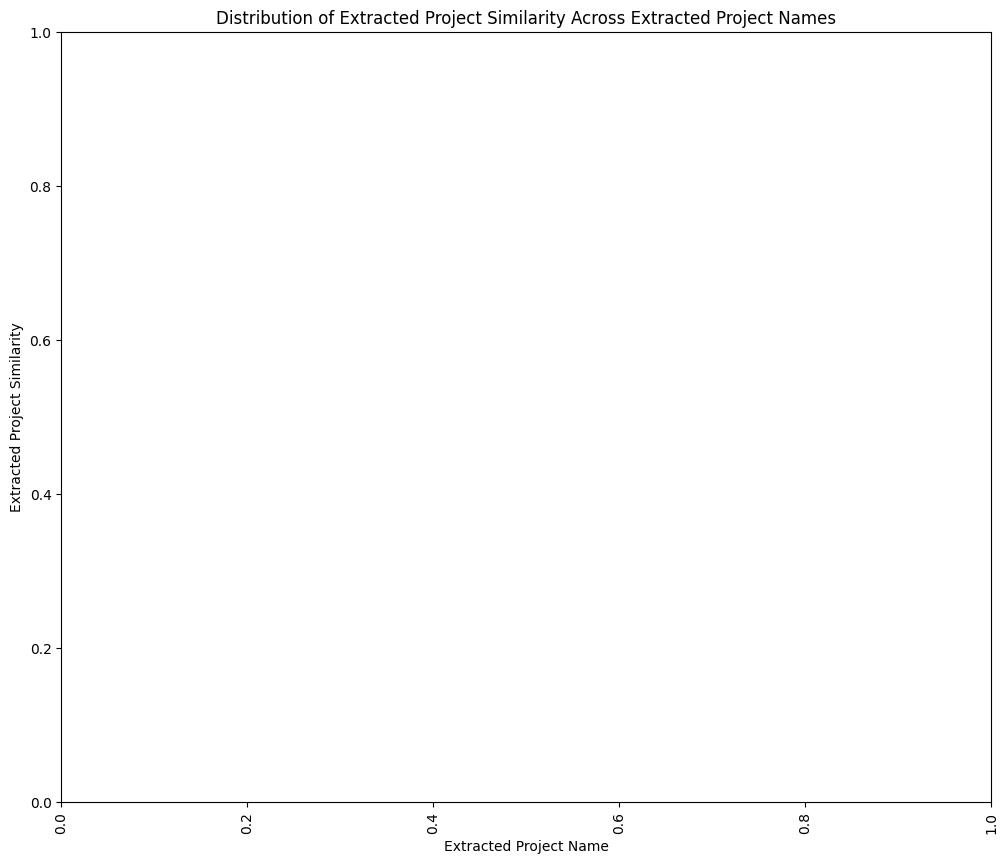

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows where 'extracted_project_similarity' is NaN
df_filtered = correct_predicted_values[correct_predicted_values["extracted_project_similarity"].notna()]

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a box plot
sns.boxplot(x="extracted_project_name", y="extracted_project_similarity", data=df_filtered)

# Optionally, create a violin plot instead of a box plot
# sns.violinplot(x="extracted_project_name", y="extracted_project_similarity", data=df_filtered)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title("Distribution of Extracted Project Similarity Across Extracted Project Names")
plt.xlabel("Extracted Project Name")
plt.ylabel("Extracted Project Similarity")

# Show the plot
plt.show()